In [14]:
import pytreenet as ptn
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy , copy

import matplotlib.pyplot as plt
import numpy as np

def plot_simulation_results(exact_solution, simulation_data):
    """
    Generate a bubble plot to visualize mean error vs simulation settings with multiple numeric types, 
    each type having a unique color indicated in the legend, and values represented as a heat map.

    Parameters:
    - exact_solution: np.ndarray, the exact solution values.
    - simulation_data: dict, where each key corresponds to a simulation setting name and value contains:
        - 'types': list of int, numeric types of simulations
        - 'values': list of float, additional values associated with each type, used for heat map
        - 'results': list of list of np.ndarray, results for each simulation type

    Returns:
    - None: Displays the plot.
    """
    labels = []
    mean_errors = []
    types = []
    values = []
    x_positions = []

    current_x = 0
    for setting, data in simulation_data.items():
        for sim_type, value, results in zip(data['types'], data['values'], data['results']):
            # Ensure results and exact_solution have matching shapes
            results = np.array(results).real
            exact_solution = exact_solution.real

            if results.shape != exact_solution.shape:
                raise ValueError(f"Shape mismatch: results shape {results.shape} and exact_solution shape {exact_solution.shape} must match.")
            
            labels.append(f"{setting} (Type: {sim_type})")
            x_positions.append(current_x)
            types.append(sim_type)
            values.append(value)

            # Calculate aggregated errors
            errors = np.abs(results - exact_solution)
            mean_errors.append(np.mean(errors))

        current_x += 1

    # Generate unique colors for each numeric type
    unique_types = sorted(set(types))
    color_map = plt.cm.get_cmap('viridis', len(unique_types))
    type_to_color = {t: color_map(i) for i, t in enumerate(unique_types)}

    # Bubble plot with distinct colors for numeric types and values as heat map
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(
        x_positions, mean_errors, 
        s=100,  # Fixed bubble size
        c=values,  # Heat map based on values
        cmap='coolwarm', 
        alpha=0.6, 
        edgecolors="w", 
        linewidth=1
    )

    # Add legend for types
    for sim_type in unique_types:
        plt.scatter([], [], color=type_to_color[sim_type], label=f"Type: {sim_type}")

    plt.colorbar(scatter, label="Values (Heat Map)")

    # Add blur lines for clarity
    max_y = max(mean_errors) * 1.2  # Extend slightly above maximum error
    for i, x in enumerate(x_positions):
        plt.plot([x, x], [0, max_y], alpha=0.5, color='gray', linewidth=1, linestyle='--')

    # Add labels and legend
    plt.xticks(range(len(simulation_data)), simulation_data.keys(), rotation=45, ha='right')
    #plt.legend(title="Simulation Type", loc='upper right', fontsize='small')

    plt.xlabel("Simulation Settings")
    plt.ylabel("Mean Error")
    plt.title("Mean Error vs Simulation Settings with Numeric Types and Values as Heat Map")
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_simulation_results(exact_solution, simulation_data):
    """
    Generate a bubble plot to visualize mean error vs simulation settings with multiple numeric types, 
    each type having a unique color indicated in the legend, and values displayed on the plot.

    Parameters:
    - exact_solution: np.ndarray, the exact solution values.
    - simulation_data: dict, where each key corresponds to a simulation setting name and value contains:
        - 'types': list of int, numeric types of simulations
        - 'values': list of float, additional values associated with each type, displayed on the plot
        - 'results': list of list of np.ndarray, results for each simulation type

    Returns:
    - None: Displays the plot.
    """
    labels = []
    mean_errors = []
    types = []
    values = []
    x_positions = []

    current_x = 0
    for setting, data in simulation_data.items():
        for sim_type, value, results in zip(data['types'], data['values'], data['results']):
            # Ensure results and exact_solution have matching shapes
            results = np.array(results).real
            exact_solution = exact_solution.real

            if results.shape != exact_solution.shape:
                raise ValueError(f"Shape mismatch: results shape {results.shape} and exact_solution shape {exact_solution.shape} must match.")
            
            labels.append(f"{setting} ({sim_type})")
            x_positions.append(current_x)
            types.append(sim_type)
            values.append(value)

            # Calculate aggregated errors
            errors = np.abs(results - exact_solution)
            mean_errors.append(np.mean(errors))

        current_x += 1

    # Generate unique colors for each numeric type
    unique_types = sorted(set(types))
    color_map = plt.cm.get_cmap('viridis', len(unique_types))
    type_to_color = {t: color_map(i) for i, t in enumerate(unique_types)}

    # Bubble plot with distinct colors for numeric types
    plt.figure(figsize=(10, 20))
    added_labels = set()  # Track added labels
    for i, (x, sim_type, value) in enumerate(zip(x_positions, types, values)):
        label = f"{sim_type}"
        plt.scatter(
            x, mean_errors[i], 
            s=100,  # Fixed bubble size
            color=type_to_color[sim_type], 
            alpha=0.6, 
            edgecolors="w", 
            linewidth=1, 
            label=label if label not in added_labels else None
        )
        added_labels.add(label)  # Add label to the set

        # Annotate the value on the plot
        plt.text(
            x, mean_errors[i], f"{value}", 
            ha='center', va='bottom', fontsize=9, color='black'
        )

    # Add blur lines for clarity
    max_y = max(mean_errors) * 1.2  # Extend slightly above maximum error
    for i, x in enumerate(x_positions):
        plt.plot([x, x], [0, max_y], alpha=0.5, color='gray', linewidth=1, linestyle='--')

    # Add labels and legend
    plt.xticks(range(len(simulation_data)), simulation_data.keys(), rotation=45, ha='right')
    plt.legend(title="bond dimensions", loc='upper right', fontsize='small')

    plt.xlabel("Simulation Settings")
    plt.ylabel("Mean Error")
    plt.title("Mean Error vs Simulation Settings with Numeric Types and Values Displayed")
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def compute_scores(profiling_data, alpha=1, gamma=1):
    """
    Compute scores for configurations based on Running Time and WPLI for a specific cache_calls_ncalls value.
    
    Parameters:
        profiling_data (list of dicts): Profiling data with keys:
                                        'Running_Time_s', 'update_tree_cache_calls', 'WPLI'.
        cache_calls_ncalls (int): The specific cache_calls value to process.
        alpha (float): Weight for Running_Time_s (smaller is better).
        gamma (float): Weight for WPLI (larger is better).
    
    Returns:
        list of dicts: Updated profiling data with additional 'Z_Running_Time_s', 
                      'Z_WPLI', 'Score', and 'Normalized_Score' keys for the specified category.
    """
    # Extract Running_Time_s and WPLI
    running_times = [d['Running_Time_s'] for d in profiling_data]
    wpli_values = [d['WPLI'] for d in profiling_data]
    
    # Compute means and standard deviations
    mean_rt = np.mean(running_times)
    std_rt = np.std(running_times)
    mean_wpli = np.mean(wpli_values)
    std_wpli = np.std(wpli_values)
    
    # Handle cases with zero standard deviation
    if std_rt == 0:
        z_rt = [0 for _ in running_times]
    else:
        z_rt = [(rt - mean_rt) / std_rt for rt in running_times]
    
    if std_wpli == 0:
        z_wpli = [0 for _ in wpli_values]
    else:
        z_wpli = [(wpli - mean_wpli) / std_wpli for wpli in wpli_values]
    
    # Invert Z_Running_Time_s because smaller is better
    z_rt = [-z for z in z_rt]
    
    # Compute composite scores using alpha and gamma
    scores = [alpha * z_rt[i] + gamma * z_wpli[i] for i in range(len(profiling_data))]
    
    # Normalize scores within the subset between 0 and 1
    min_score = min(scores)
    max_score = max(scores)
    
    if max_score == min_score:
        # If all scores are identical, assign normalized score of 1.0
        normalized_scores = [1.0 for _ in scores]
    else:
        normalized_scores = [(s - min_score) / (max_score - min_score) for s in scores]
    
    # Update the profiling_data entries that match the current cache_calls category
    for i, entry in enumerate(profiling_data):
        entry['Z_Running_Time_s'] = z_rt[i]
        entry['Z_WPLI'] = z_wpli[i]
        entry['Score'] = scores[i]
        entry['Normalized_Score'] = normalized_scores[i]
    
    return profiling_data

def compute_scores(profiling_data, alpha=1, beta=1, gamma=1):
    """
    Compute scores for configurations based on Running Time, update_tree_cache_calls, and WPLI.
    
    Parameters:
        profiling_data (list of dicts): Profiling data with normalized keys:
                                        'Norm_Running_Time_s', 'Norm_update_tree_cache_calls', 'Norm_WPLI'.
        alpha (float): Weight for Running Time (smaller is better).
        beta (float): Weight for update_tree_cache_calls (larger is better).
        gamma (float): Weight for WPLI (larger is better).
    
    Returns:
        list of dicts: Updated profiling data with an additional 'Score' key.
    """
    # Normalize the profiling data
    for entry in profiling_data:
        entry['Norm_Running_Time_s'] = (entry['Running_Time_s'] - min(d['Running_Time_s'] for d in profiling_data)) / (max(d['Running_Time_s'] for d in profiling_data) - min(d['Running_Time_s'] for d in profiling_data))
        entry['Norm_update_tree_cache_calls'] = (entry['update_tree_cache_calls'] - min(d['update_tree_cache_calls'] for d in profiling_data)) / (max(d['update_tree_cache_calls'] for d in profiling_data) - min(d['update_tree_cache_calls'] for d in profiling_data))
        entry['Norm_WPLI'] = (entry['WPLI'] - min(d['WPLI'] for d in profiling_data)) / (max(d['WPLI'] for d in profiling_data) - min(d['WPLI'] for d in profiling_data))

    scored_data = []
    for entry in profiling_data:
        # Compute score using normalized values
        score = (
            alpha * (1 - entry['Norm_Running_Time_s']) +
            beta * (1 - entry['Norm_update_tree_cache_calls'])  +
            gamma * entry['Norm_WPLI']
        )
        # Append score to the entry
        scored_entry = entry.copy()
        scored_entry['Score'] = score
        scored_data.append(scored_entry)

    # Normalize the scores
    min_score = min(d['Score'] for d in scored_data)
    max_score = max(d['Score'] for d in scored_data)
    for entry in scored_data:
        entry['Normalized_Score'] = (entry['Score'] - min_score) / (max_score - min_score)    
    return scored_data


# Exact (Qutip)

In [8]:
# System initialization
Lx = 4
Ly = 4

t = 2
u = 0.2
mu = 0

n_bosons = 2
system = ptn.BoseHubbard2D_Qutip(Lx, Ly, n_bosons, t, u, mu , periodic= True)

# Create initial state
black_state = np.array([0,1])
white_state = np.array([1,0])
psi0 = system.alternating_product_state(black_state, white_state, pattern= "checkerboard")
#psi0 = system.uniform_product_state([1/np.sqrt(2), 1/np.sqrt(2)])
# Evolve system
end_time = 1
dt = 0.02
result = system.evolve_system(psi0, end_time=end_time, dt=dt)

In [3]:
import pickle
import pandas as pd
from tabulate import tabulate

# Load the Pickle file
with open('tdvp_profiling_data_3.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# Extract profiling data (not profiling details)
profiling_data = loaded_data['profiling_data']
unique_cache_calls = set(entry['update_tree_cache_calls'] for entry in profiling_data)
unique_cache_calls = sorted(unique_cache_calls)
print("Available cache_calls_ncalls values:", unique_cache_calls)

# Compute scores using the profiling_data
# Ensure ptn.compute_scores is compatible with this structure
scored_data = ptn.compute_scores_old(profiling_data, alpha=1, beta=2, gamma=1)

#scored_data = ptn.compute_scores___(profiling_data, 30 ,alpha=1, gamma=1)
#scored_data = compute_scores(profiling_data, alpha=1, gamma=0)

#scored_data = compute_scores(profiling_data, alpha=4, beta=2, gamma=1)

# Convert the scored data to a DataFrame for display
scored_df = pd.DataFrame(scored_data)

# Sort the DataFrame by the 'Score' column in descending order
scored_df = scored_df.sort_values(by='Score', ascending=False)

# Display the top configurations
print("\n=== Top Configurations ===")
print(tabulate(scored_df, headers='keys', tablefmt='pretty'))


Available cache_calls_ncalls values: [30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50]

=== Top Configurations ===
+-----+------------+---------------------+-------------------------+--------------------+------------------------+---------------------------+-----------------------+-----------------------+----------------------+
|     | Config_ID  |   Running_Time_s    | update_tree_cache_calls |        WPLI        |    Z_Running_Time_s    | Z_update_tree_cache_calls |        Z_WPLI         |         Score         |   Normalized_Score   |
+-----+------------+---------------------+-------------------------+--------------------+------------------------+---------------------------+-----------------------+-----------------------+----------------------+
| 170 | Config 172 | 0.5091342926025391  |           30            | 4.853109690149354  |   0.404779483211922    |     3.047293509399169     |  -1.9569274692354084  |   4.542439032774851   |         1.0          |
| 127 | Config 129 |  0.6887910366

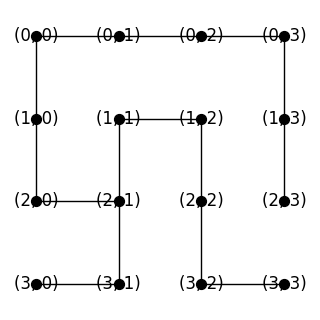

In [4]:
import pickle
# Load the Pickle file
with open('tdvp_profiling_data_3.pkl', 'rb') as f:
    profiling_data = pickle.load(f)

# Extract profiling details from the loaded data
profiling_details = profiling_data['profiling_details']

config_id = 'Config 189'
bond_dim = 10
ttn = profiling_details[config_id]['Spanning_tree']
ptn.Visualize_tree(profiling_details[config_id]['tree_dict'],6)  

In [27]:
configs = ['Config 172','Config 1', 'Config 6', 'Config 15', 'Config 28', 'Config 29', 'Config 30', 'Config 31', 'Config 32', 'Config 35', 'Config 39', 'Config 42', 'Config 51', 'Config 52', 'Config 57', 'Config 58', 'Config 60', 'Config 63', 'Config 65', 'Config 66', 'Config 68', 'Config 76', 'Config 80', 'Config 81', 'Config 83', 'Config 85', 'Config 86', 'Config 89', 'Config 91', 'Config 92', 'Config 93', 'Config 96', 'Config 101', 'Config 102', 'Config 104', 'Config 106', 'Config 108', 'Config 109', 'Config 113', 'Config 117', 'Config 128', 'Config 131', 'Config 135', 'Config 136', 'Config 139', 'Config 140', 'Config 154', 'Config 157', 'Config 158', 'Config 163', 'Config 165', 'Config 171', 'Config 173', 'Config 176', 'Config 178', 'Config 179', 'Config 183', 'Config 193', 'Config 200']
bond_dims = {
    "Config 172": 45,
    "Config 96": 45,
    "Config 117": 40,
    "Config 42": 45,
    "Config 114": 45,
    "Config 193": 40,
    "Config 175": 40,
    "Config 163": 35,
    "Config 183": 40,
    "Config 35": 45,
    "Config 176": 45,
    "Config 52": 30,
    "Config 135": 25,
    "Config 165": 40,
    "Config 32": 40,
    "Config 128": 45,
    "Config 200": 45,
    "Config 86": 45,
    "Config 58": 40,
    "Config 108": 40,
    "Config 31": 35,
    "Config 63": 35,
    "Config 65": 30,
    "Config 154": 45,
    "Config 109": 45,
    "Config 171": 45,
    "Config 93": 40,
    "Config 57": 40,
    "Config 30": 35,
    "Config 39": 45,
    "Config 6": 35,
    "Config 60": 20,
    "Config 85": 25,
    "Config 158": 22,
    "Config 95": 22,
    "Config 179": 18,
    "Config 101": 35,
    "Config 26": 40,
    "Config 15": 30,
    "Config 83": 30,
    "Config 140": 30,
    "Config 106": 30,
    "Config 81": 25,
    "Config 29": 30,
    "Config 1": 35,
    "Config 173": 22,
    "Config 104": 25,
    "Config 89": 25,
    "Config 178": 18,
    "Config 80": 40,
    "Config 91": 40,
    "Config 177": 40,
    "Config 76": 35,
    "Config 92": 25,
    "Config 113": 18,
    "Config 157": 25,
    "Config 66": 18,
    "Config 68": 30,
    "Config 28": 25,
    "Config 139": 30,
    "Config 136": 25,
    "Config 102": 18,
    "Config 51": 18,
    "Config 131": 18,
}


with open('tdvp_profiling_data_3.pkl', 'rb') as f:
    loaded_data = pickle.load(f)
profiling_data = loaded_data['profiling_data']  
WPLI = {}

for config in profiling_data:
    WPLI[config['Config_ID']] = config['WPLI']
WPLI = {key: WPLI[key] for key in configs if key in WPLI}


SCORE = {}
for config in scored_data:
    SCORE[config['Config_ID']] = config['Normalized_Score']  
SCORE = {key: SCORE[key] for key in configs if key in SCORE}


# Directory and filename structure
base_path = r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2'

# Create the dictionary
import os

# Corrected dictionary creation with space between "config" and n
results_dict = {}
for config in configs:
    file_number = config.split()[-1]  # Extract the number from "Config n"
    file_path = os.path.join(base_path, f"{file_number}.npz")
    try:
        # Load the data if the file exists
        results_dict[f"config {file_number}"] = np.load(file_path)["operator0results"]
    except FileNotFoundError:
        print(f"File not found: {file_path}")

# Display the created dictionary keys
results_dict


mean_error_dict = {
    key: np.mean(np.abs(value - correlation_exact))
    for key, value in results_dict.items()
}


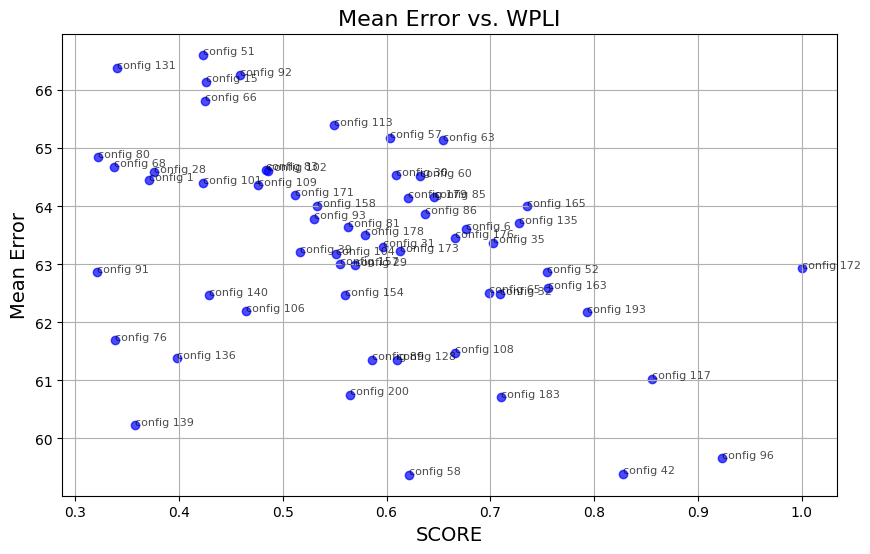

In [29]:
# Assuming mean_error_dict and WPLI are already defined in your environment
x_values = [SCORE[key] for key in SCORE if f"config {key.split()[-1]}" in mean_error_dict]
y_values = [mean_error_dict[f"config {key.split()[-1]}"] for key in SCORE if f"config {key.split()[-1]}" in mean_error_dict]

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, color='blue', alpha=0.7)

# Add labels and title
plt.xlabel('SCORE', fontsize=14)
plt.ylabel('Mean Error', fontsize=14)
plt.title('Mean Error vs. WPLI', fontsize=16)
plt.grid(True)


# Annotate points with their respective configurations
for i, (x, y) in enumerate(zip(x_values, y_values)):
    config_label = list(mean_error_dict.keys())[i]  # Retrieve the configuration label
    plt.annotate(config_label, (x, y), fontsize=8, alpha=0.7)

# Show plot
plt.show()

In [842]:
SCORE["Config 52"]

0.754742438535166

In [836]:
mean_error_dict

{'config 172': 0.10938514969295515,
 'config 1': 0.121709131893225,
 'config 6': 0.10226889955590182,
 'config 15': 0.13958533279959834,
 'config 28': 0.11357386447538034,
 'config 29': 0.09491754798176673,
 'config 30': 0.12317570700526773,
 'config 31': 0.10904413155947523,
 'config 32': 0.0821651185417976,
 'config 35': 0.09185943308073959,
 'config 39': 0.09476816347724462,
 'config 42': 0.07269674601859218,
 'config 51': 0.1450646630186645,
 'config 52': 0.09219033225358117,
 'config 57': 0.12267479629394575,
 'config 58': 0.07161959534914542,
 'config 60': 0.12060601114942057,
 'config 63': 0.11828019641667033,
 'config 65': 0.09176775395756433,
 'config 66': 0.1345711938506004,
 'config 68': 0.13709721877931155,
 'config 76': 0.08083774626988106,
 'config 80': 0.12372960174335694,
 'config 81': 0.0978878022030721,
 'config 83': 0.11267203650067935,
 'config 85': 0.1158851131334744,
 'config 86': 0.10004180736920203,
 'config 89': 0.0824469996831509,
 'config 91': 0.0981184621991

C:\Users\edpou\AppData\Local\Temp\ipykernel_26464\1540555532.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab10', len(unique_bond_dims))


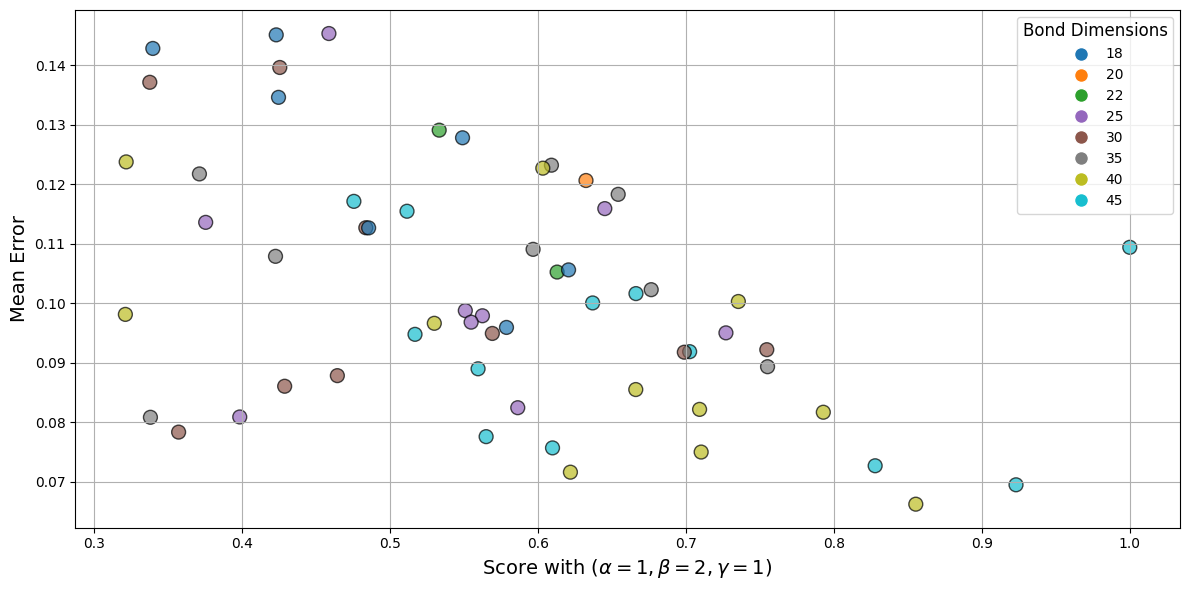

In [810]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Assuming `SCORE`, `mean_error_dict`, and `bond_dims` are already defined

# Map bond dimensions to unique colors
unique_bond_dims = sorted(set(bond_dims.values()))
color_map = plt.cm.get_cmap('tab10', len(unique_bond_dims))
bond_dim_to_color = {bond_dim: color_map(i) for i, bond_dim in enumerate(unique_bond_dims)}

# Filter data for plotting
x_values = []
y_values = []
colors = []

for key in SCORE:
    config_label = f"config {key.split()[-1]}"
    if config_label in mean_error_dict:
        x_values.append(SCORE[key])
        y_values.append(mean_error_dict[config_label])
        bond_dim = bond_dims.get(key, None)
        if bond_dim is not None:
            colors.append(bond_dim_to_color[bond_dim])

# Create scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(x_values, y_values, c=colors, alpha=0.7, edgecolors='k', s=100)

# Add labels and title
plt.xlabel(r'Score with $(\alpha=1, \beta=2, \gamma=1)$', fontsize=14)
plt.ylabel('Mean Error', fontsize=14)
plt.title('', fontsize=16)
plt.grid(True)

# Create a legend for bond dimensions
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f"{bond_dim}",
           markerfacecolor=bond_dim_to_color[bond_dim], markersize=10)
    for bond_dim in unique_bond_dims
]
plt.legend(handles=legend_elements, title="Bond Dimensions", fontsize=10, title_fontsize=12 , loc='upper right')

# Show plot
plt.tight_layout()
plt.show()

In [785]:
local_state = np.array([1/np.sqrt(2), 1/np.sqrt(2)])
ttn = ptn.uniform_product_state(ttn ,local_state, bond_dim= 2)

black_state = np.array([0+0j, 1+0j])
white_state = np.array([1+0j, 0+0j])
ttn = ptn.alternating_product_state(ttn, black_state, white_state, bond_dim = bond_dim,  pattern = "checkerboard")

t = 2
u = 0.2
m = 0
Lx = 4
Ly = 4

H1 = ptn.BoseHubbard_ham(t, u, m, Lx, Ly, 2, boundary_condition= "periodic")
H1 = H1.pad_with_identities(ttn , symbolic= True)
ttno = ptn.TTNO.from_hamiltonian(H1, ttn)

Correlation_function = ptn.Correlation_function("Site(0,0)", "Site(3,3)", 2)
Correlation_function = Correlation_function.pad_with_identities(ttn, symbolic= True)
Correlation_function_longest = ptn.TTNO.from_hamiltonian(Correlation_function, ttn)

DDC_function = ptn.density_density_correlation_function(4,4,3,2)
DDC_function = DDC_function.pad_with_identities(ttn, symbolic= True)
DDC_function = ptn.TTNO.from_hamiltonian(DDC_function, ttn)

I = ptn.TTNO.Identity(ttn)

In [656]:
expaction_params = {
            "mode" : "Krylov", # "Krylov" or "Taylor"
            "size_threshold" : 500, # no higher approximation in default

            # "Krylov" parameters
            "Krylov_tol"  : 1e-5,
            "krylov_dim"   : 5,

            # "Taylor" parameters
            "Taylor_num_terms"  : 3}

expansion_params = {"ExpansionMode": ptn.ExpansionMode.No_expansion,
                    "num_vecs": 3, 
                    "tau": 0.01,
                    "SVDParameters": ptn.SVDParameters(max_bond_dim = np.inf , rel_tol= 1e-3 , total_tol = -np.inf),
                    "expansion_steps" : 60,
                    "tol": 0.5,
                    "tol_step_increase": 0.08,
                    "tol_step_decrease": 0.03,
                    "num_second_trial" : 10,
                    "max_bond": 200,
                    "rel_tot_bond": (20,40),
                    "T3N_dict" : {'Site(1,1)': 'Site(0,1)',
                                'Site(2,1)': 'Site(2,0)',
                                'Site(2,2)': 'Site(3,2)',}}

config= ptn.TTNTimeEvolutionConfig(record_bond_dim = True,
                                   ExpAction_params= expaction_params,
                                   Expansion_params = expansion_params)    

tdvp = ptn.SecondOrderOneSiteTDVP(initial_state = ttn,
                                 hamiltonian = ttno,
                                 time_step_size = 0.02,
                                 final_time = 1,
                                 operators = [DDC_function , Correlation_function_longest],
                                 config = config)

In [657]:
tdvp.RUN(evaluation_time = 1 , filepath = r"C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\175")
times = tdvp.times()

100%|██████████| 51/51 [17:47<00:00, 20.92s/it]


C:\Users\edpou\AppData\Local\Temp\ipykernel_26464\2404148321.py:134: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(unique_types))


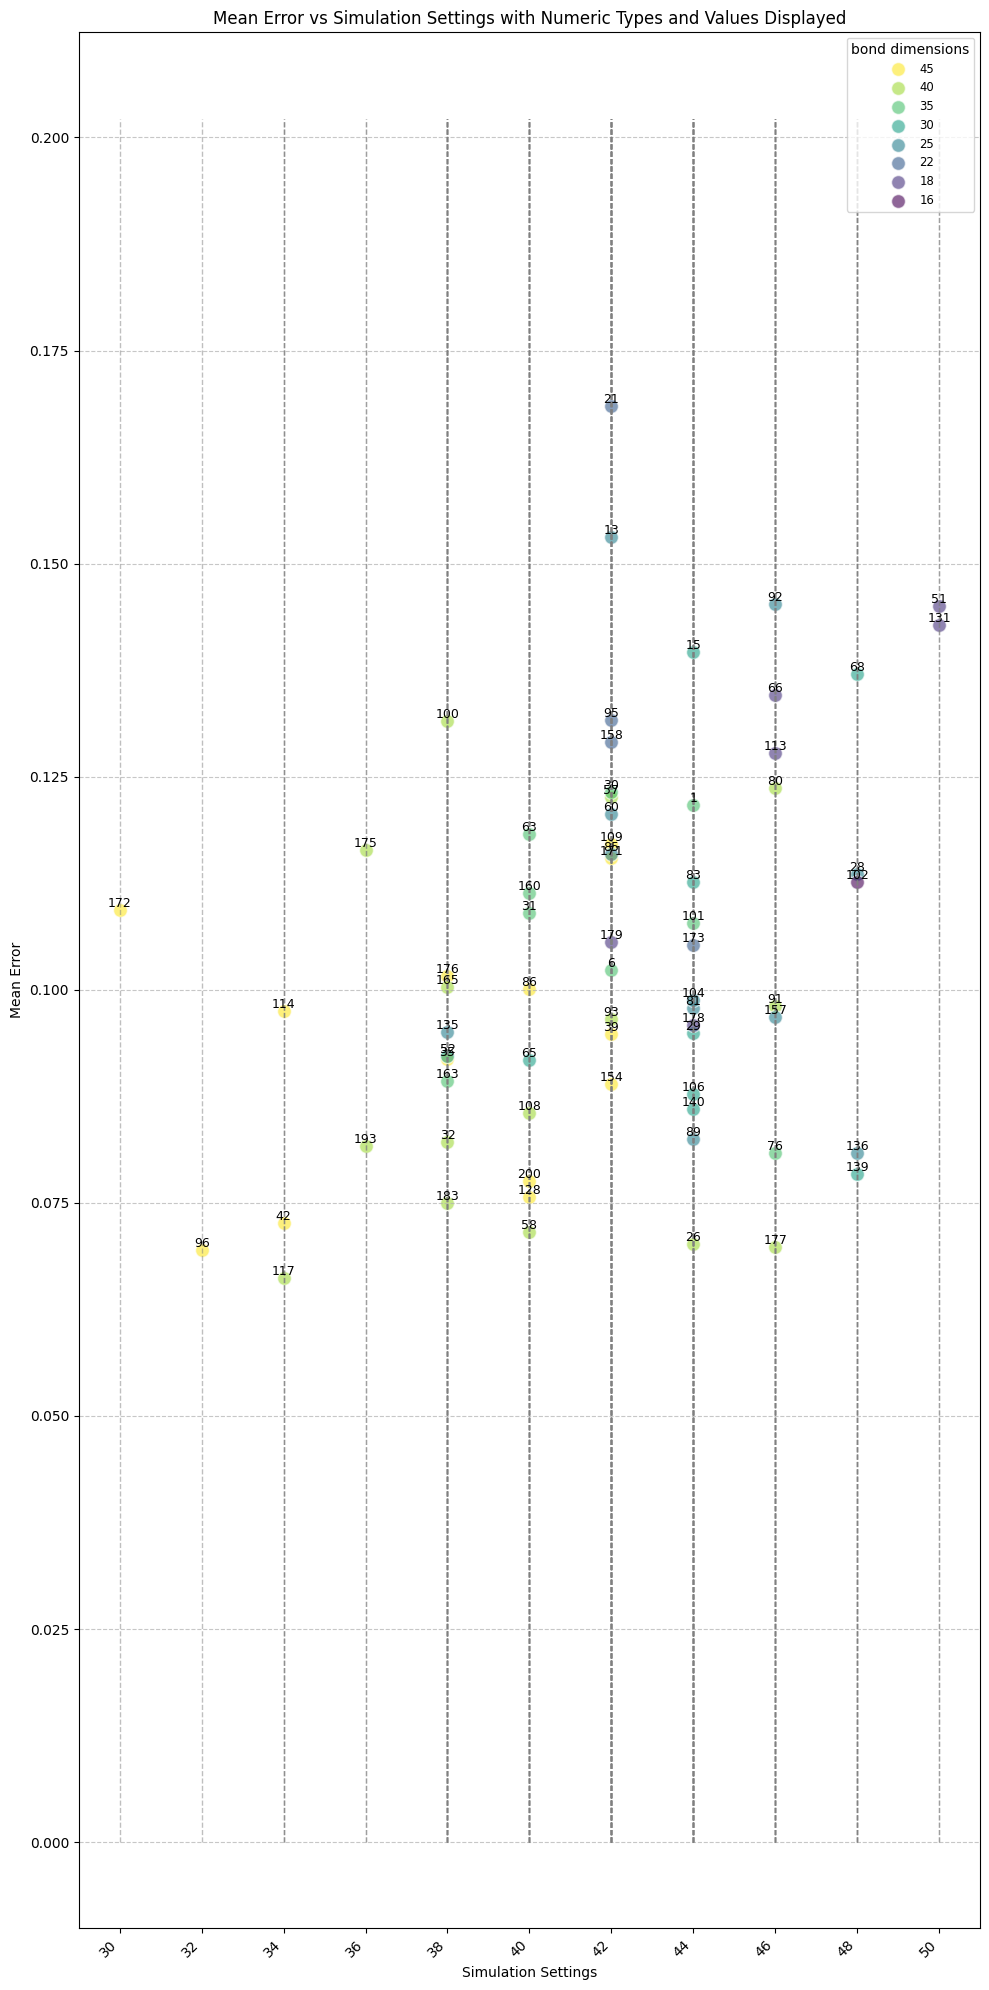

In [676]:
import matplotlib.pyplot as plt
import numpy as np

exact_solution = correlation_exact

simulation_data = {
        '30': {
    'types': [45],
    'values': [172],
    'results': [
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\172.npz')["operator0results"],]},
        '32': {
    'types': [45],
    'values': [96],
    'results': [
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\96.npz')["operator0results"],]},
        '34': {
    'types': [40 , 45 , 45], 
    'values': [117, 42 , 114],
    'results': [
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\117.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\42.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\114.npz')["operator0results"],]},
        '36': {
    'types': [40, 40 ], 
    'values': [193 , 175],
    'results': [
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\193.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\175.npz')["operator0results"],]},
        '38': {
    'types':   [35 , 40, 45,  40 , 45, 30,  25, 40,  40], 
    'values': [163, 183, 35, 100, 176, 52, 135, 165, 32],
    'results': [
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\163.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\183.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\35.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\100.npz')["operator0results"],        
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\176.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\52.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\135.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\165.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\32.npz')["operator0results"],
        ]},
        '40': {
    'types':   [45 , 45, 45, 40, 40, 35,  35, 35,  30], 
    'values': [128, 200, 86, 58, 108, 31, 160, 63, 65],
    'results': [
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\128.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\200.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\86.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\58.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\108.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\31.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\160.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\63.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\65.npz')["operator0results"],
        ]},
        '42': {
    'types':  [45,  45,  45,  40, 40, 35, 45,35, 25, 25, 25,  22, 22, 18,  22],
    'values': [154, 109, 171, 93, 57, 30, 39, 6, 60, 13, 85, 158, 95, 179, 21],
    'results': [
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\154.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\109.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\171.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\93.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\57.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\30.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\39.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\6.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\60.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\13.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\85.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\158.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\95.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\179.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\21.npz')["operator0results"],
        ]},        
        '44': {
    'types': [ 35,  40, 30, 30, 30,  30,  25, 30, 35,  22,  25, 25,  18],
    'values': [101, 26, 15, 83, 140, 106, 81, 29,  1, 173, 104, 89, 178],
    'results': [
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\101.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\26.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\15.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\83.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\140.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\106.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\81.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\29.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\1.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\173.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\104.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\89.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\178.npz')["operator0results"],
        ]},
        '46': {
    'types': [40, 40, 40, 35, 25, 18, 25, 18],
    'values': [80, 91, 177, 76, 92, 113, 157, 66],
    'results': [
       np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\80.npz')["operator0results"],
       np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\91.npz')["operator0results"],
       np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\177.npz')["operator0results"],
       np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\76.npz')["operator0results"],
       np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\92.npz')["operator0results"],
       np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\113.npz')["operator0results"],
       np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\157.npz')["operator0results"],
       np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\66.npz')["operator0results"],
        ]},   
        '48': {
    'types':  [30, 25,  30,  25,  16],
    'values': [68, 28, 139, 136, 102],
    'results': [
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\68.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\28.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\139.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\136.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\102.npz')["operator0results"],
        ]},   
        '50': {
    'types':  [18, 18,],
    'values': [51, 131],
    'results': [
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\51.npz')["operator0results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\131.npz')["operator0results"],
        ]},
}

plot_simulation_results(exact_solution, simulation_data)



C:\Users\edpou\AppData\Local\Temp\ipykernel_26464\1715979994.py:134: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(unique_types))


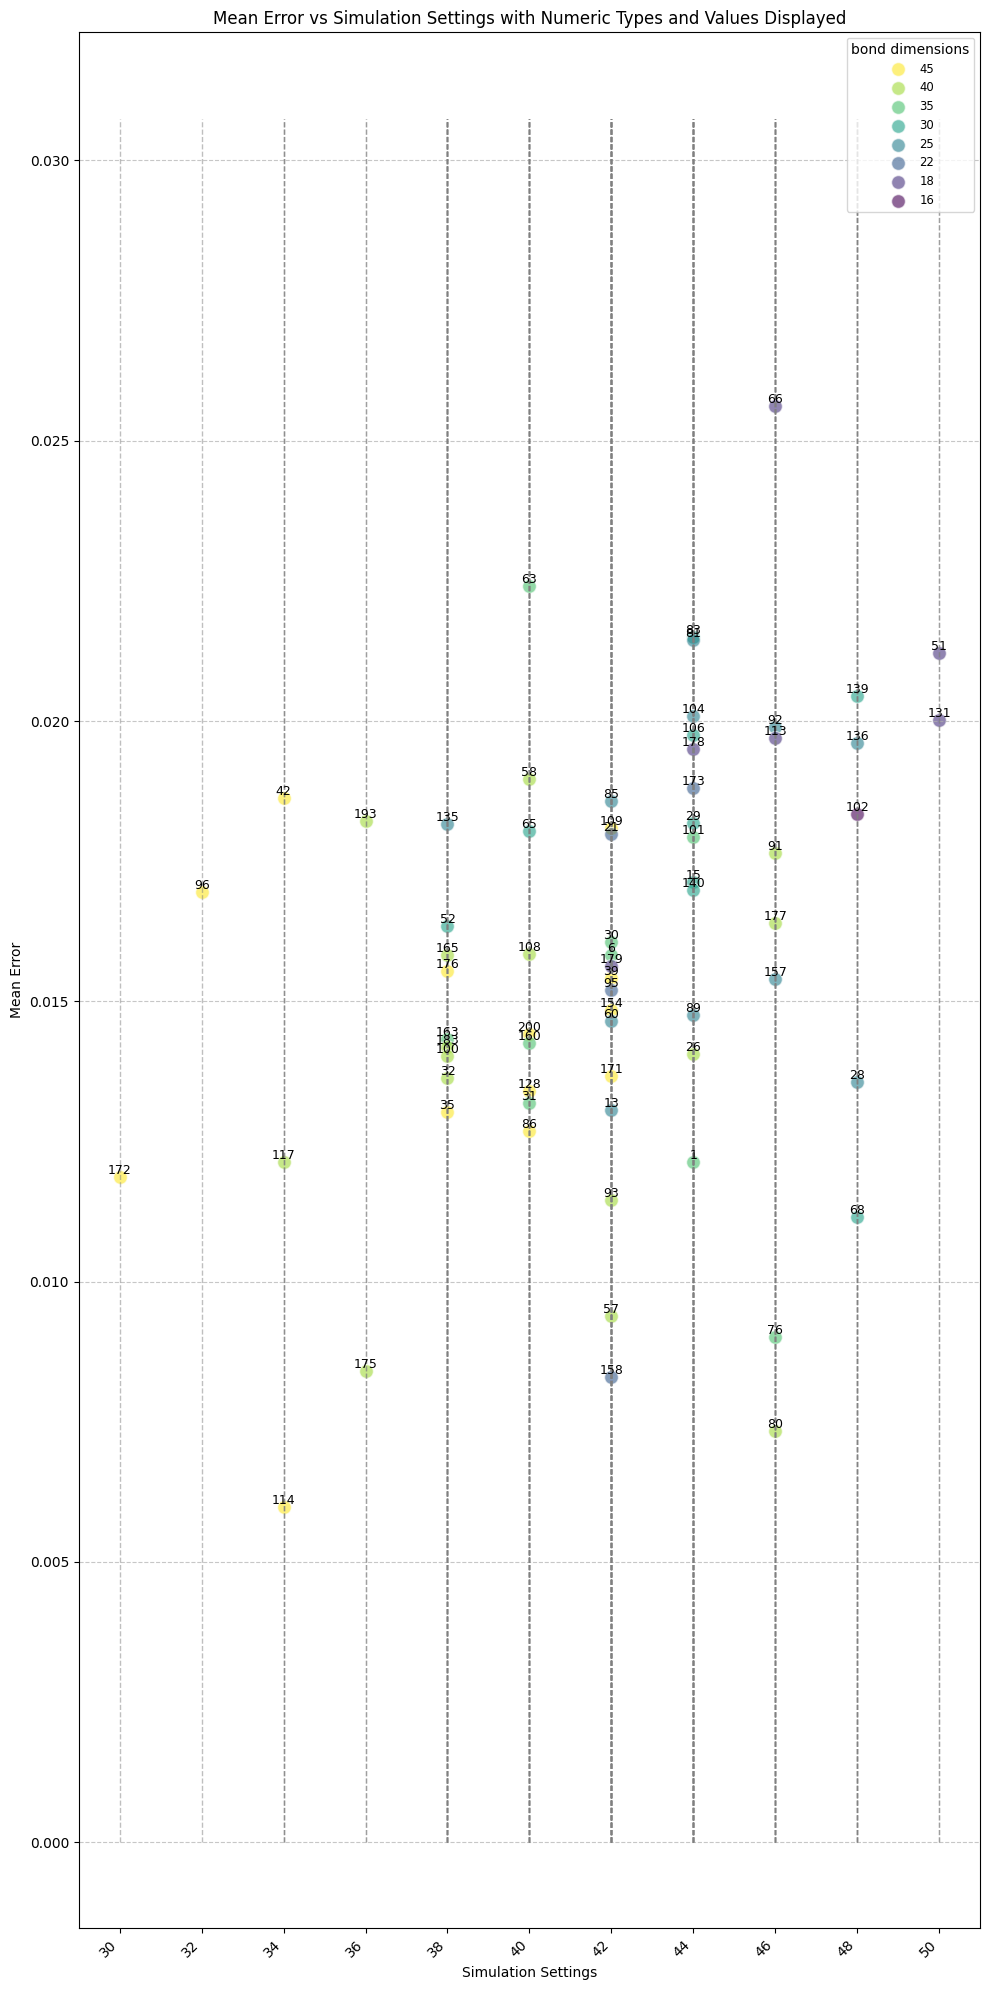

In [169]:
exact_solution = correlation_exact_longest

simulation_data = {
        '30': {
    'types': [45],
    'values': [172],
    'results': [
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\172.npz')["operator1results"],]},
        '32': {
    'types': [45],
    'values': [96],
    'results': [
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\96.npz')["operator1results"],]},
        '34': {
    'types': [40 , 45 , 45], 
    'values': [117, 42 , 114],
    'results': [
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\117.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\42.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\114.npz')["operator1results"],]},
        '36': {
    'types': [40, 40 ], 
    'values': [193 , 175],
    'results': [
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\193.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\175.npz')["operator1results"],]},
        '38': {
    'types':   [35 , 40, 45,  40 , 45, 30,  25, 40,  40], 
    'values': [163, 183, 35, 100, 176, 52, 135, 165, 32],
    'results': [
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\163.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\183.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\35.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\100.npz')["operator1results"],        
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\176.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\52.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\135.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\165.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\32.npz')["operator1results"],
        ]},
        '40': {
    'types':   [45 , 45, 45, 40, 40, 35,  35, 35,  30], 
    'values': [128, 200, 86, 58, 108, 31, 160, 63, 65],
    'results': [
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\128.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\200.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\86.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\58.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\108.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\31.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\160.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\63.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\65.npz')["operator1results"],
        ]},
        '42': {
    'types':  [45,  45,  45,  40, 40, 35, 45,35, 25, 25, 25,  22, 22, 18,  22],
    'values': [154, 109, 171, 93, 57, 30, 39, 6, 60, 13, 85, 158, 95, 179, 21],
    'results': [
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\154.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\109.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\171.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\93.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\57.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\30.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\39.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\6.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\60.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\13.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\85.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\158.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\95.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\179.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\21.npz')["operator1results"],
        ]},        
        '44': {
    'types': [ 35,  40, 30, 30, 30,  30,  25, 30, 35,  22,  25, 25,  18],
    'values': [101, 26, 15, 83, 140, 106, 81, 29,  1, 173, 104, 89, 178],
    'results': [
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\101.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\26.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\15.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\83.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\140.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\106.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\81.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\29.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\1.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\173.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\104.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\89.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\178.npz')["operator1results"],
        ]},
        '46': {
    'types': [40, 40, 40, 35, 25, 18, 25, 18],
    'values': [80, 91, 177, 76, 92, 113, 157, 66],
    'results': [
       np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\80.npz')["operator1results"],
       np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\91.npz')["operator1results"],
       np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\177.npz')["operator1results"],
       np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\76.npz')["operator1results"],
       np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\92.npz')["operator1results"],
       np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\113.npz')["operator1results"],
       np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\157.npz')["operator1results"],
       np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\66.npz')["operator1results"],
        ]},   
        '48': {
    'types':  [30, 25,  30,  25,  16],
    'values': [68, 28, 139, 136, 102],
    'results': [
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\68.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\28.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\139.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\136.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\102.npz')["operator1results"],
        ]},   
        '50': {
    'types':  [18, 18,],
    'values': [51, 131],
    'results': [
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\51.npz')["operator1results"],
        np.load(r'C:\Users\edpou\Desktop\Ed\PyTreeNet-Project_09\PyTreeNet\results_2\131.npz')["operator1results"],
        ]},
}

plot_simulation_results(exact_solution, simulation_data)



In [205]:
correlation_exact

array([0.        +0.j, 0.03807328+0.j, 0.14841765+0.j, 0.31975216+0.j,
       0.53445258+0.j, 0.77037334+0.j, 1.00339791+0.j, 1.21049278+0.j,
       1.37283444+0.j, 1.47840294+0.j, 1.52345794+0.j, 1.51253282+0.j,
       1.45696895+0.j, 1.37240571+0.j, 1.27587786+0.j, 1.18318293+0.j,
       1.10699684+0.j, 1.05591586+0.j, 1.03433934+0.j, 1.04294064+0.j,
       1.07941545+0.j, 1.13924774+0.j, 1.21633539+0.j, 1.3034545 +0.j,
       1.39265233+0.j, 1.47571395+0.j, 1.54480471+0.j, 1.59327504+0.j,
       1.61647484+0.j, 1.61235644+0.j, 1.58168773+0.j, 1.52783596+0.j,
       1.45623767+0.j, 1.37375013+0.j, 1.28804703+0.j, 1.20710471+0.j,
       1.13871158+0.j, 1.08988478+0.j, 1.06613356+0.j, 1.07062678+0.j,
       1.10344621+0.j, 1.16117665+0.j, 1.23704813+0.j, 1.32173845+0.j,
       1.40473462+0.j, 1.47598697+0.j, 1.52746607+0.j, 1.55427124+0.j,
       1.55507166+0.j, 1.53187992+0.j, 1.4893294 +0.j])

c:\Users\edpou\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\edpou\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


NameError: name 'tdvp' is not defined

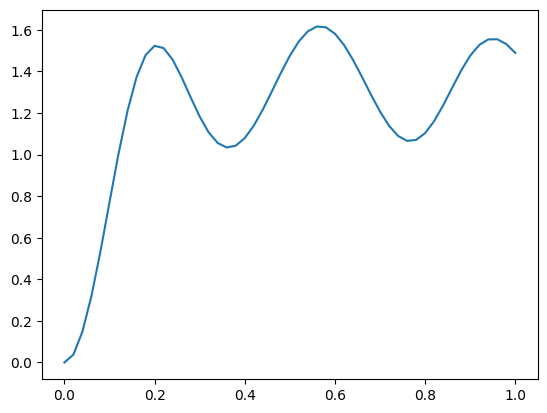

In [7]:
correlation_exact, eval_times = system.density_density_correlation_results(evaluation_time = 1, 
                                                                            results = result, 
                                                                            distance = 3, 
                                                                            mode="HV", 
                                                                            Normalize=False)

plt.plot(eval_times, correlation_exact, label="exact")
plt.plot(eval_times,tdvp.operator_results()[0], label="tdvp")
plt.legend()

NameError: name 'tdvp' is not defined

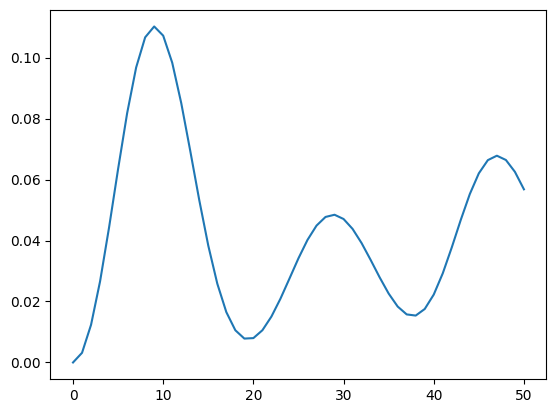

In [11]:
correlation_exact_longest, eval_times = system.specific_site_correlation_results(evaluation_time=1,
                                                                     results=result ,
                                                                     site1 = (0,0),
                                                                     site2 = (3,3),
                                                                     normalize = False)

plt.plot(correlation_exact_longest, label="exact")
plt.plot(tdvp.operator_results()[1], label="tdvp")
plt.legend()

C:\Users\edpou\AppData\Local\Temp\ipykernel_3388\575452628.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')  # Choose a colormap with more distinct colors


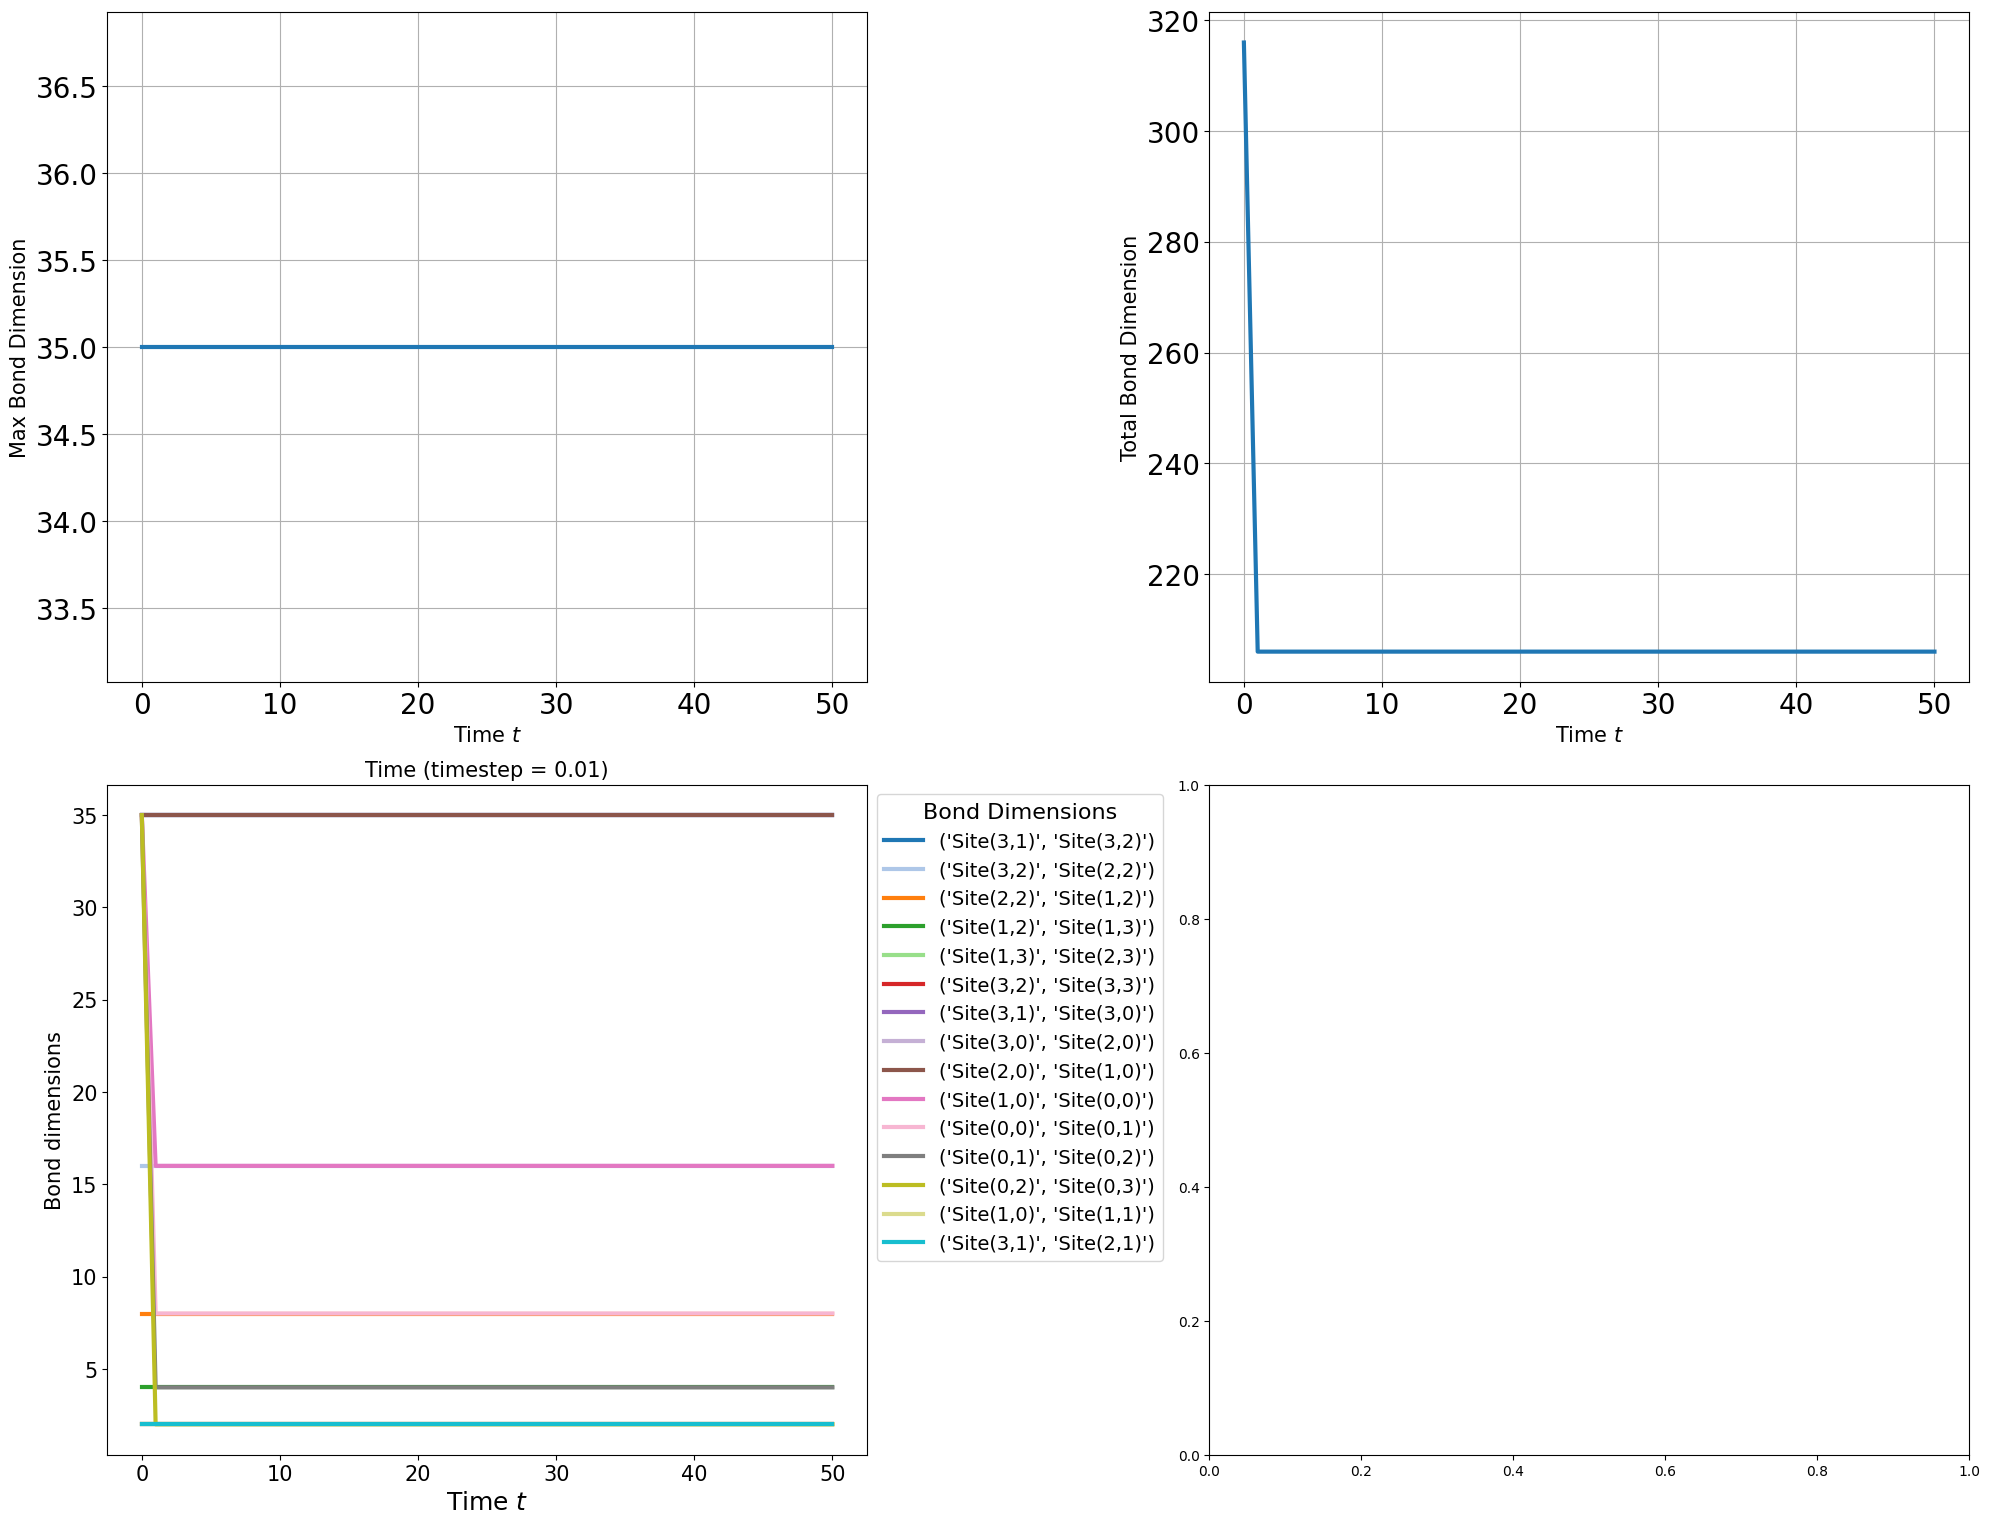

In [397]:
import matplotlib.pyplot as plt

def get_distinct_colors(n):
    """Generates a list of n distinct, visually appealing colors using colormap cyclically."""
    from matplotlib.cm import get_cmap
    cmap = get_cmap('tab20')  # Choose a colormap with more distinct colors
    return [cmap(i / n) for i in range(n)]

# Create a figure with a grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

# Plot max bond dimension
axs[0, 0].plot(tdvp.max_bond_dim, linewidth=3)
axs[0, 0].set_xlabel("Time $t$", fontsize=15)
axs[0, 0].set_ylabel('Max Bond Dimension', fontsize=15)
axs[0, 0].tick_params(axis='both', which='major', labelsize=20)
axs[0, 0].grid(True)

# Plot total bond dimension
axs[0, 1].plot(tdvp.total_bond_dim, linewidth=3)
axs[0, 1].set_xlabel("Time $t$", fontsize=15)
axs[0, 1].set_ylabel('Total Bond Dimension', fontsize=15)
axs[0, 1].tick_params(axis='both', which='major', labelsize=20)
axs[0, 1].grid(True)

# Plot bond dimensions for each key
colors = get_distinct_colors(len(tdvp.bond_dims))
for i, (key, values) in enumerate(tdvp.bond_dims.items()):
    x = list(range(len(values)))
    axs[1, 0].plot(x, values, label=key, color=colors[i], linewidth=3)
axs[1, 0].legend(title='Bond Dimensions', loc='upper left', bbox_to_anchor=(1, 1), fontsize=14, title_fontsize=16)
axs[1, 0].set_xlabel("Time $t$", fontsize=18)
axs[1, 0].set_ylabel('Bond dimensions', fontsize=15)
axs[1, 0].set_title('Time (timestep = 0.01)', fontsize=15)
axs[1, 0].tick_params(axis='both', which='major', labelsize=15)
plt.subplots_adjust(right=0.8)


# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title

# Show the plot
plt.show()


In [10]:
oc_exact, times = system.occupation_results(evaluation_time=2,results=result)
oc_exact_00 = oc_exact[:,2,2]
oc_tenpy, times = model.occupation_results(psi_list= psi_evolved, evaluation_time=2, dt = 0.01)
oc_tenpy = oc_tenpy[:,2,2]
oc_tdvp = tdvp.operator_results()[1]

plt.plot(times, abs(oc_tdvp - oc_exact_00) / oc_exact_00 , label="1tdvp - 2 min")
plt.plot(times, abs(oc_tenpy - oc_exact_00) / oc_exact_00 , label="tenpy - 5 min")
#plt.plot(times, oc_exact_00, label="exact")

plt.title("(0,0) occupation error")
plt.xlabel("Time")
plt.ylabel("Spatial Correlation")
plt.legend()
plt.show()

NameError: name 'model' is not defined

In [17]:
correlation_exact, eval_times = system.specific_site_correlation_results(evaluation_time=1,
                                                                     results=result ,
                                                                     site1 = (0,0),
                                                                     site2 = (3,3),
                                                                     normalize = False)


plt.plot(times, abs(tdvp.operator_results()[0]), label="1tdvp - 2 min")
#plt.plot(times, correlation_tenpy, label="tenpy - 5 min")
plt.plot(times, correlation_exact, label="exact")

plt.title("(0,0)-(3,3) Correlation")
plt.xlabel("Time")
plt.ylabel("Spatial Correlation")
plt.legend()
plt.show()

NameError: name 'tdvp' is not defined

In [ ]:
# 2TDVP on MPS (TenPy)
![image-2.png](attachment:image-2.png)
# Set up parameters
Lx = 4
Ly = 4
n_bosons = 2
t = 2
U = 0.1
mu = 0.5

# Create model and initial state
model = ptn.BoseHubbard2D_Tenpy(Lx, Ly, n_bosons, t, U, mu)
black_state = [0, 1]  # |0>
white_state = [1, 0]  # |1>
mps = model.alternating_product_state_custom(black_state, white_state, pattern="checkerboard")

# Print initial state energy
print("Initial energy:", model.H_MPO.expectation_value(mps))

# Print initial occupation for a few sites
print("Initial occupations:")
occ_initial = model.calculate_occupation(mps)
print(occ_initial)  # Print first 2x2 corner

# Evolution parameters
lanczos_params = {
    'N_min': 2,           # Min number of Lanczos steps per /5
    'N_max': 20,          # Max number of Lanczos steps per evolution step/20
    'P_tol': 1e-6,       # Tolerance for convergence in Lanczos /1e-14
    'reortho': False}     # Reorthogonalize vectors in the Krylov space /False
   

# Evolve the state
psi_evolved = model.evolve_system_two_site(mps, 
                                           end_time = 2,
                                           dt = 0.01, 
                                           chi_max = 80, 
                                           svd_min = 1e-3, 
                                           lanczos_params=lanczos_params) 

In [ ]:
# remove open leg
new_tensor = self.state.tensors[node_id].reshape(self.state.tensors[node_id].shape[:-1])
open_leg = self.state.nodes[node_id].open_legs[0]
self.state.nodes[node_id]._leg_permutation.pop(open_leg)
self.state.tensors[node_id] = new_tensor
self.state.nodes[node_id].link_tensor(new_tensor)

self.state.contract_nodes(node_id, 
                            next_node_id,
                            new_identifier = next_node_id)
next_next_neighbour_id = self.orthogonalization_path[update_index+1][0]
main_legs, next_legs = build_leg_specs(self.state.nodes[next_node_id], next_next_neighbour_id)
self.state.split_node_it(next_node_id , main_legs, next_legs,
                            identifier_a= "3_" + next_node_id,
                            identifier_b= next_node_id)  

# add open leg  
shape = self.state.tensors[node_id].shape
T = self.state.tensors[node_id].reshape(shape + (1,))
self.state.nodes[node_id]._leg_permutation.append(open_leg)
self.state.tensors[node_id] = T 
self.state.nodes[node_id].link_tensor(T)           

new_tensor = contract_any(node_id, next_node_id,
                            self.state, self.hamiltonian,
                            self.partial_tree_cache)
self.partial_tree_cache.add_entry(node_id, next_node_id, new_tensor)

self.state.orthogonality_center_id = next_node_id

In [48]:
import pickle
import pandas as pd
from tabulate import tabulate

# Load the Pickle file
with open('tdvp_profiling_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# Extract profiling data (not profiling details)
profiling_data = loaded_data['profiling_data']
unique_cache_calls = set(entry['update_tree_cache_calls'] for entry in profiling_data)
unique_cache_calls = sorted(unique_cache_calls)
print("Available cache_calls_ncalls values:", unique_cache_calls)

# Compute scores using the profiling_data
# Ensure ptn.compute_scores is compatible with this structure
scored_data = ptn.compute_scores(profiling_data, 48 , alpha=1, gamma=1)

# Convert the scored data to a DataFrame for display
scored_df = pd.DataFrame(scored_data)

# Sort the DataFrame by the 'Score' column in descending order
scored_df = scored_df.sort_values(by='Score', ascending=False)

# Display the top configurations
print("\n=== Top Configurations ===")
print(tabulate(scored_df, headers='keys', tablefmt='pretty'))


Available cache_calls_ncalls values: [30, 32, 34, 36, 38, 40, 42, 44, 46, 48]

=== Top Configurations ===
+---+------------+--------------------+-------------------------+--------------------+----------------------+-----------------------+----------------------+--------------------+
|   | Config_ID  |   Running_Time_s   | update_tree_cache_calls |        WPLI        |   Z_Running_Time_s   |        Z_WPLI         |        Score         |  Normalized_Score  |
+---+------------+--------------------+-------------------------+--------------------+----------------------+-----------------------+----------------------+--------------------+
| 3 | Config 89  | 0.269913911819458  |           48            | 16.48307858602574  |  1.193760495160961   | -0.060628676321351764 |  1.1331318188396093  |        1.0         |
| 1 | Config 12  | 1.6364412307739258 |           48            | 20.546044343334266 | -0.6399613277832296  |  1.6787666814852058   |  1.0388053537019761  | 0.9708246518601573 |
| 5 